In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
df_list = []

In [4]:
folder_path = '../../Dataset/Group04/'

all_entries = os.listdir(folder_path)

In [5]:
print(all_entries)


['LS_Group04', 'NLS_Group04.txt', 'rd_group4']


In [10]:
# Assuming the data is in a file called 'data.txt' in the folder path
file_path = folder_path + 'NLS_Group04.txt'

# Read the file into a DataFrame, skip the first row of headers
data = pd.read_csv(file_path, delim_whitespace=True, header=None, skiprows=1)

# Check the shape and preview the data
# print("Shape of the data:", data.shape)
# print(data.head())

# The first two columns should contain the numeric values, drop any extra columns
data = data.iloc[:, :2]  # Keep only the first two columns

# Create the class labels
labels = []

# Class 1 for first 300 examples
labels.extend([1] * 300)

# Class 2 for next 500 examples
labels.extend([2] * 500)

# Class 3 for last 1000 examples
labels.extend([3] * 1000)

# Add the class labels as a new column
data['Class'] = labels

# Rename the columns
data.columns = ['Feature1', 'Feature2', 'Class']

# View the updated DataFrame
print(data)


      Feature1  Feature2  Class
0    -0.190176 -0.195489      1
1    -0.208340  0.107337      1
2    -0.487379  0.131786      1
3    -0.564656 -0.193942      1
4     0.527243 -0.166957      1
...        ...       ...    ...
1795  4.221331 -0.045618      3
1796  4.483162  2.921077      3
1797 -0.524097  3.659981      3
1798 -3.563939 -4.183029      3
1799 -4.781256 -0.034948      3

[1800 rows x 3 columns]


In [8]:
merged_df = pd.concat(df_list, ignore_index=True)

In [11]:
merged_df = data

In [12]:
print(merged_df.head())

   Feature1  Feature2  Class
0 -0.190176 -0.195489      1
1 -0.208340  0.107337      1
2 -0.487379  0.131786      1
3 -0.564656 -0.193942      1
4  0.527243 -0.166957      1


In [13]:
merged_df.shape

(1800, 3)

In [12]:
plt.figure(figsize=(10,10))

for class_name in merged_df['Class'].unique():
    print(class_name)

Class1
Class2
Class3


<Figure size 1000x1000 with 0 Axes>

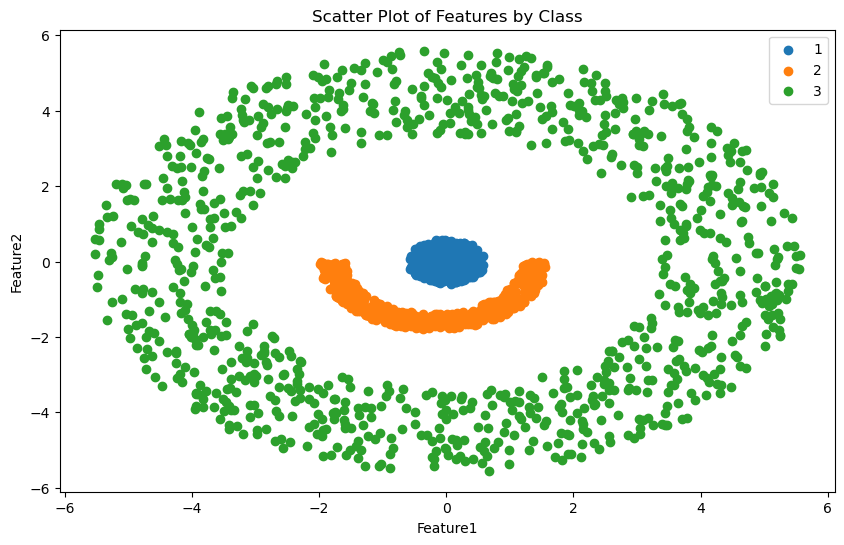

In [14]:
df = merged_df[["Feature1","Feature2","Class"]]
plt.figure(figsize=(10, 6))
for cls in df['Class'].unique():
    subset = df[df['Class'] == cls]
    plt.scatter(subset['Feature1'], subset['Feature2'], label=cls)

plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Scatter Plot of Features by Class')
plt.legend()
plt.show()

In [15]:
print(merged_df.isna().sum())

Feature1    0
Feature2    0
Class       0
dtype: int64


In [17]:
# import matplotlib.pyplot as plt

# plt.scatter(df['Feature1'], df['Feature2'])
# plt.title('Class1 Data Distribution')
# plt.xlabel('Feature1')
# plt.ylabel('Feature2')
# plt.show()

In [18]:
def mean(x: list[float]) -> float:
    ''' Docstring 
    
    '''
    return sum(x)/len(x)

def covariance(x: list[float],y: list[float]) -> float:
    ''' Docstring dfghjk
    
    '''
    if len(x) != len(y):
        raise ValueError("Length mismatch between input lists")
    numerator = 0
    x_mean = mean(x)
    y_mean = mean(y)
    for i, j in zip(x,y):
        numerator += (i-x_mean)*(j-y_mean)
        
    return numerator/(len(x)-1)

def covariance_matrix(class_data, mean_vector=0):
    n_samples = len(class_data)
    n_features = 2
    cov_matrix = [[0.0] * n_features for _ in range(n_features)]
    
    for i in range(n_features):
        for j in range(n_features):
            cov_matrix[i][j] = covariance(class_data.iloc[:, i], class_data.iloc[:, j])
    return cov_matrix

In [19]:
covariance([1,2,3],[1,4,6])

2.5

In [20]:
df['Class'].unique()

array([1, 2, 3], dtype=int64)

In [21]:
covariance_matrix(merged_df)

[[6.069435053566833, 0.14164446562103886],
 [0.14164446562103886, 6.496130081072395]]

In [22]:
def average_variance(class_dataset):
    total_variance = 0
    total_count = 0
    for class_data in class_dataset:
        cov_mat = covariance_matrix(class_data)
        for i in range(len(cov_mat)):
            total_variance += cov_mat[i][i]
            total_count += 1
    return total_variance/total_count

def shared_covariance_matrix_sigma_squared_I(class_datasets: list):
    sigma_squared = average_variance(class_datasets)
    n_features = len(class_datasets[0].columns)
    return [[sigma_squared if i == j else 0 for j in range(n_features)] for i in range(n_features)]

In [24]:
def compute_class_means_and_priors(train_df):
    class_means = {}
    priors = {}

    total_samples = len(train_df)

    for cls in train_df['Class'].unique():
        class_data = train_df[train_df['Class'] == cls][['Feature1', 'Feature2']]
        feature1_values = class_data['Feature1'].tolist()
        feature2_values = class_data['Feature2'].tolist()
        
        mean_feature1 = sum(feature1_values) / len(feature1_values)
        mean_feature2 = sum(feature2_values) / len(feature2_values)

        class_means[cls] = [mean_feature1, mean_feature2]
        priors[cls] = len(class_data) / total_samples

    return class_means, priors

def discriminant_sigma2I(x, mean_vec, sigma2, prior):
    x = np.array(x)
    mean_vec = np.array(mean_vec)

    diff = x - mean_vec
    term1 = -0.5 * np.dot(diff.T, diff) / sigma2
    term2 = np.log(prior)

    return term1 + term2
    

def predict_sigma2I(test_df, class_means, priors, sigma2):
    predictions = []

    for _, row in test_df.iterrows():
        x = [row['Feature1'], row['Feature2']]
        scores = {}

        for cls in class_means:
            score = discriminant_sigma2I(x, class_means[cls], sigma2, priors[cls])
            scores[cls] = score

        predicted_class = max(scores, key=scores.get)
        predictions.append(predicted_class)

    return predictions



In [25]:
import numpy as np
train_df = merged_df
test_df = merged_df.copy()
class_data_train = [train_df[train_df['Class'] == c][['Feature1', 'Feature2']] for c in train_df['Class'].unique()]

# Step 3: Get sigma²
sigma2_cov = shared_covariance_matrix_sigma_squared_I(class_data_train)
sigma2 = sigma2_cov[0][0]  # since diagonal and same for all

# Step 4: Compute means and priors
class_means, priors = compute_class_means_and_priors(train_df)

# Step 5: Predict
test_df['Predicted'] = predict_sigma2I(train_df, class_means, priors, sigma2)

['Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',
 'Class3',

In [26]:
def confusion_matrix(true_labels, predicted_labels, classes):
    # Initialize matrix as dict of dicts for clarity
    matrix = {true_cls: {pred_cls: 0 for pred_cls in classes} for true_cls in classes}

    for t, p in zip(true_labels, predicted_labels):
        matrix[t][p] += 1

    return matrix

def accuracy(true_labels, predicted_labels):
    correct = sum(t == p for t, p in zip(true_labels, predicted_labels))
    total = len(true_labels)
    return correct / total if total > 0 else 0

def precision_recall_f1(conf_matrix, classes):
    precision = {}
    recall = {}
    f1 = {}

    for cls in classes:
        TP = conf_matrix[cls][cls]
        FP = sum(conf_matrix[other][cls] for other in classes if other != cls)
        FN = sum(conf_matrix[cls][other] for other in classes if other != cls)

        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

        precision[cls] = prec
        recall[cls] = rec
        f1[cls] = f1_score

    mean_precision = sum(precision.values()) / len(classes)
    mean_recall = sum(recall.values()) / len(classes)
    mean_f1 = sum(f1.values()) / len(classes)

    return precision, recall, f1, mean_precision, mean_recall, mean_f1


In [27]:
true_labels = test_df['Class'].tolist()
predicted_labels = test_df['Predicted'].tolist()
classes = list(test_df['Class'].unique())

cm = confusion_matrix(true_labels, predicted_labels, classes)
acc = accuracy(true_labels, predicted_labels)
prec, rec, f1, mean_prec, mean_rec, mean_f1 = precision_recall_f1(cm, classes)

print("\n\nConfusion Matrix:\n", cm)
print("\n\nAccuracy:\n", acc)
print("\n\nPrecision per class:\n", prec)
print("\n\nRecall per class:\n", rec)
print("\n\nF1 Score per class:\n", f1)
print("\n\nMean Precision:\n", mean_prec)
print("\n\nMean Recall:\n", mean_rec)
print("\n\nMean F1 Score:\n", mean_f1)




Confusion Matrix:
 {1: {1: 0, 2: 0, 3: 300}, 2: {1: 0, 2: 0, 3: 500}, 3: {1: 0, 2: 259, 3: 741}}


Accuracy:
 0.4116666666666667


Precision per class:
 {1: 0, 2: 0.0, 3: 0.4808565866320571}


Recall per class:
 {1: 0.0, 2: 0.0, 3: 0.741}


F1 Score per class:
 {1: 0, 2: 0, 3: 0.5832349468713106}


Mean Precision:
 0.16028552887735237


Mean Recall:
 0.247


Mean F1 Score:
 0.19441164895710353


In [28]:
import pandas as pd
import numpy
df = merged_df
# Load data
# df = pd.read_csv("your_data.csv")  # Replace with actual filename

# Split data into list of DataFrames by class
class_data = [df[df['Class'] == c][['Feature1', 'Feature2']] for c in df['Class'].unique()]

# Get shared covariance matrix of form σ² * I
shared_cov = shared_covariance_matrix_sigma_squared_I(class_data)

# Display
print("Shared Covariance Matrix (σ² * I):")
print(shared_cov)

Shared Covariance Matrix (σ² * I):
[[3.86305373698753, 0], [0, 3.86305373698753]]


In [29]:
int main()

SyntaxError: invalid syntax (1063484020.py, line 1)